In [1]:
import configs_py3 as configs
import utilities as utils
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

/n/fs/nlp-runzhey/miniconda3/envs/iw_vqa/lib/python3.7/site-packages/transformers/models/yolos/feature_extraction_yolos.py:31: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  FutureWarning,
/n/fs/nlp-runzhey/miniconda3/envs/iw_vqa/lib/python3.7/site-packages/transformers/models/yolos/image_processing_yolos.py:707: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  FutureWarning,


In [10]:
def get_abstain_output(df, is_val=True, thresholds=np.arange(0.1, 1.0, 0.1)):
   
    
    abstain_y_true_dict = {}
    
    abstain_y_pred_dict = {}
    
   
    
    for threshold in thresholds:
            
            threshold = round(threshold,1)
            
            abstain_y_true_list = []
            abstain_y_pred_list = []
            
            for index, row in df.iterrows():
                
                model_output = row[f'thresholded_model_outputs_{threshold}']  
                abstain_y_pred = 1 if model_output == "ABSTAIN" else 0  
                
                if is_val:          
                    
                    abstain_y_true = 0  if index < len(df)//2 else 1
                
                else:
                    abstain_y_true = 1
                
                
                abstain_y_true_list.append(abstain_y_true)
                abstain_y_pred_list.append(abstain_y_pred) 
                

            abstain_y_true_dict[threshold] = abstain_y_true_list
            abstain_y_pred_dict[threshold] = abstain_y_pred_list
            
                    
    return abstain_y_true_dict, abstain_y_pred_dict

In [9]:
def get_abstain_classification_report(df, is_val=True, thresholds=np.arange(0.1, 1.0, 0.1), output_dict=True):
    abstain_classification_report_dict = {}
    
    
    
    abstain_y_true_dict, abstain_y_pred_dict = get_abstain_output(df, is_val, thresholds=thresholds)
    
    for threshold in thresholds:
            threshold = round(threshold,1)
            
            abstain_classification_report_dict[threshold] = classification_report(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold], output_dict=output_dict)
            
                    
    return abstain_classification_report_dict


In [8]:
def get_pred_accuracy_scores(df, is_val=True, thresholds=np.arange(0.1, 1.0, 0.1)):
    
    pred_accuracy_score = {}
     
    for threshold in thresholds:
            
            threshold = round(threshold,1)
            
            pred_correct_sum  = 0
            for index, row in df.iterrows():
                
                model_output = row[f'thresholded_model_outputs_{threshold}']
                if is_val==True:
                    if index < len(df)//2:
                        desired_outputs = df.answers[index].replace("[", "").replace("]", "")
                        desired_outputs = eval(desired_outputs)

                        desired_outputs = pd.DataFrame(desired_outputs)
                        desired_outputs = desired_outputs.answer.to_list()
                        
                    else:
                        desired_outputs = ["ABSTAIN"]
                
                else:
                    desired_outputs = ["ABSTAIN"]
         
                if model_output in desired_outputs:
                    
                    pred_correct_sum +=1
                
            pred_accuracy_score[threshold] = pred_correct_sum / len(df)    

    return pred_accuracy_score


In [7]:
def get_thresholded_outputs(df, thresholds=np.arange(0.1, 1.0, 0.1)):

    for threshold in thresholds:
        threshold = round(threshold,1)
        thresholded_model_outputs = utils.get_thresholded_output(df["original_model_outputs"], df["softmax_outputs"], threshold=threshold)
        df[f'thresholded_model_outputs_{threshold}'] = thresholded_model_outputs
    
    df.to_csv(configs.output_path, index=False)
    return df


In [ ]:
def create_results_file(prefix="thresholded_model_outputs", thresholds=np.arange(0.1, 1.0, 0.1)):
    # create results file in required format
    df = pd.read_csv(configs.output_path, index_col=False)

    results = []
    for threshold in thresholds:
        threshold = round(threshold,1)
        for index, row in df.iterrows():
            question_id = row['question_id']
            answer = row[f'{prefix}_{threshold}']
            result = {"question_id": question_id, "answer": answer}
            results.append(result)

        # store results in json file

        resFile = '%s/Results/%s%s_%s_%s_results_%s.json' %(configs.dataDir, configs.versionType, configs.taskType, 
                                                            configs.dataType, configs.dataSubType, threshold)
        json.dump(results, open(resFile, 'w'))
    
    return results


In [ ]:
def get_evals(df, is_val=True, thresholds=np.arange(0.1, 1.0, 0.1)):
    
    
    abstain_classification_report_dict, abstain_y_true_dict, abstain_y_pred_dict = get_abstain_classification_report(df, is_val=is_val, thresholds=thresholds)
    
    pred_accuracy_score = get_pred_accuracy_scores(df, is_val=is_val, thresholds=thresholds)
    
    return abstain_classification_report_dict, abstain_y_true_dict, abstain_y_pred_dict, pred_accuracy_score


In [5]:
val_df = df=utils.load_dataset("val")

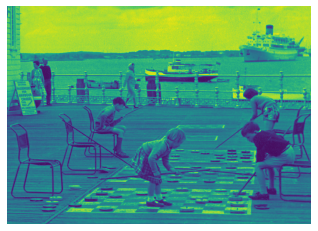

Unsupported number of image dimensions: 2 ==> Skipping this image


In [12]:
val_df = utils.get_preds(val_df)

In [13]:
val_df = get_thresholded_outputs(val_df)

In [14]:
abstain_accuracy_dict = {}
for threshold, report in get_abstain_classification_report(val_df).items():
        
        abstain_accuracy_dict[threshold] = report['accuracy']  
pred_accuracy_score= get_pred_accuracy_scores(val_df)

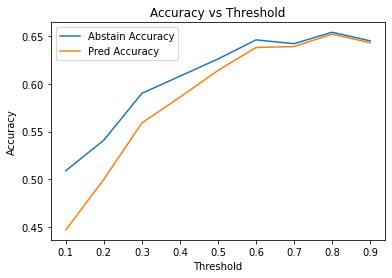

In [15]:
plt.plot(list(abstain_accuracy_dict.keys()), list(abstain_accuracy_dict.values()), label='Abstain Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')

plt.plot(list(pred_accuracy_score.keys()), list(pred_accuracy_score.values()), label="Pred Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Threshold")
plt.show()


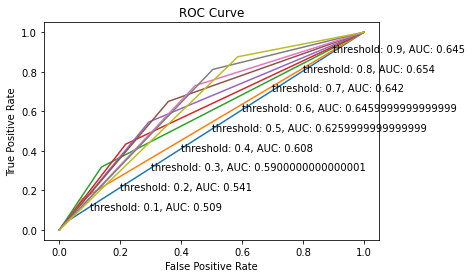

In [16]:
abstain_y_true_dict, abstain_y_pred_dict = get_abstain_output(val_df)
for threshold in np.arange(0.1, 1.0, 0.1):
            threshold = round(threshold,1)
            
            
            plt.plot(*roc_curve(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold])[:2], label=f"threshold: {threshold}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
           
            plt.annotate(f"threshold: {threshold}, AUC: {auc(*roc_curve(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold])[:2])}", (threshold, threshold))
            
plt.title("ROC Curve")
plt.show()
            
    

In [17]:
threshold = 0.5

raw_output = pd.read_csv(configs.output_path, index_col=False)[f"thresholded_model_outputs_{threshold}"]

related_question_output = raw_output[:len(raw_output)//2]
unrelated_question_output = raw_output[len(raw_output)//2:]
distribution_of_answers_df = pd.DataFrame({"related_question_output": related_question_output.value_counts(), 
                                        "unrelated_question_output": unrelated_question_output.value_counts()})
distribution_of_answers_df.to_csv("%s/output/%s-distribution-of-answers.csv" % (configs.ROOT, date.today()))

In [18]:
# show top 25 answers
distribution_of_answers_df.sort_values(by="unrelated_question_output", ascending=False).head(25)

,related_question_output,unrelated_question_output
ABSTAIN,147.0,273.0
nothing,2.0,26.0
white,16.0,22.0
black,7.0,14.0
brown,8.0,9.0
blue,13.0,7.0
nowhere,NaN,7.0
green,9.0,6.0
0,NaN,4.0
outside,NaN,3.0


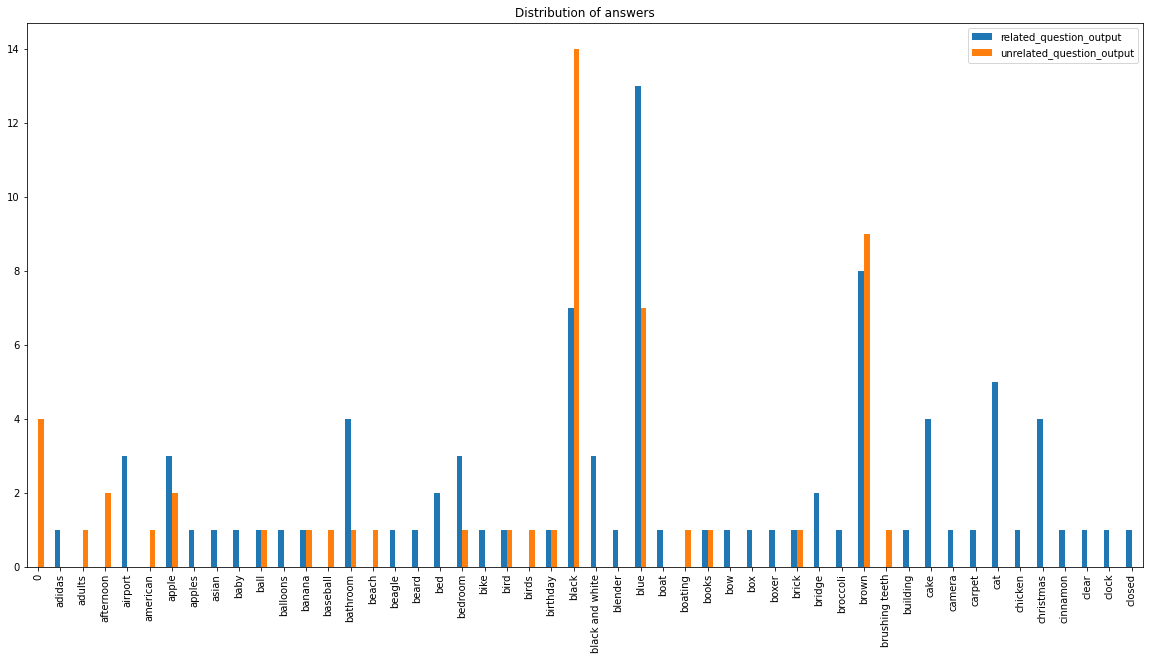

In [19]:
# plot histogram after removing ABSTAIN
distribution_of_answers_df.drop(["ABSTAIN"]).head(50).plot(kind='bar', figsize=(20,10), title="Distribution of answers")
plt.show()